# Example of usage Spark OCR for recognize text from Image and selectable PDF's  and store results to PDF with text layout

## Install spark-ocr python packge
Need specify path to `spark-ocr-assembly-[version].jar` or `secret`

In [1]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"

In [ ]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    java -version
fi

In [ ]:
import sys
import os

if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [ ]:
# install from PYPI using secret
%pip install spark-ocr==$version --user --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [2]:
# or install from local path
%pip install --user ../../python/dist/spark-ocr-1.2.0.tar.gz

Processing /Users/nmelnik/IdeaProjects/spark-ocr/python/dist/spark-ocr-1.2.0.tar.gz
  Created wheel for spark-ocr: filename=spark_ocr-1.2.0-py3-none-any.whl size=5012116 sha256=b79c63e97b4235bbb3c7e061d6a42840bb1886c0351fa6e52262964bfe8333f3
  Stored in directory: /Users/nmelnik/Library/Caches/pip/wheels/8f/18/a8/6a746cb146272537dd3c50b17baa2711dab0a33acc5ed77549
Successfully built spark-ocr
  Attempting uninstall: spark-ocr
    Found existing installation: spark-ocr 1.1.2
    Uninstalling spark-ocr-1.1.2:
      Successfully uninstalled spark-ocr-1.1.2
Note: you may need to restart the kernel to use updated packages.


## Initialization of spark session

In [3]:
from pyspark.sql import SparkSession
from sparkocr import start

if license:
    os.environ['JSL_OCR_LICENSE'] = license

spark = start(secret=secret, jar_path=spark_ocr_jar_path)
spark

SparkConf Configured, Starting to listen on port: 56355
JAR PATH:/usr/local/lib/python3.7/site-packages/sparkmonitor/listener.jar


## Import OCR transformers

In [4]:
from sparkocr.transformers import *
from sparkocr.enums import *
from pyspark.ml import PipelineModel
from sparkocr.utils import display_image

## Define OCR transformers and pipeline

In [11]:
def pipeline():
    
    # If text PDF extract text
    pdf_to_text = PdfToText() \
        .setInputCol("content") \
        .setOutputCol("text") \
        .setSplitPage(False)
    
    # If image pdf, extract image
    pdf_to_image = PdfToImage() \
        .setInputCol("content") \
        .setOutputCol("image") \
        .setKeepInput(True)
    
    # Run OCR
    ocr = ImageToText() \
        .setInputCol("image") \
        .setOutputCol("text") \
        .setConfidenceThreshold(60) \
        .setIgnoreResolution(False) \
        .setPageSegMode(PageSegmentationMode.SPARSE_TEXT)
    
    # Render results to PDF
    textToPdf = TextToPdf() \
        .setInputCol("positions") \
        .setInputImage("image") \
        .setOutputCol("pdf")

    pipeline = PipelineModel(stages=[
        pdf_to_text,
        pdf_to_image,
        ocr,
        textToPdf
    ])
    
    return pipeline

## Read PDF document as binary file

In [6]:
import pkg_resources
pdf_example = pkg_resources.resource_filename('sparkocr', 'resources/ocr/pdfs/multiplepages/*')
pdf_example_df = spark.read.format("binaryFile").load(pdf_example).cache()

## Run OCR pipelines

In [12]:
result = pipeline().transform(pdf_example_df).cache()

## Store results to pdf file

In [13]:
pdf = result.select("pdf").head().pdf
pdfFile = open("result.pdf", "wb")
pdfFile.write(pdf)
pdfFile.close()

## Convert pdf to image and display 

Image:
        origin: file:/Users/nmelnik/Library/Python/3.7/lib/python/site-packages/sparkocr/resources/ocr/pdfs/multiplepages/text_3_pages.pdf 
        width: 2480
        height: 3507
        mode: 10


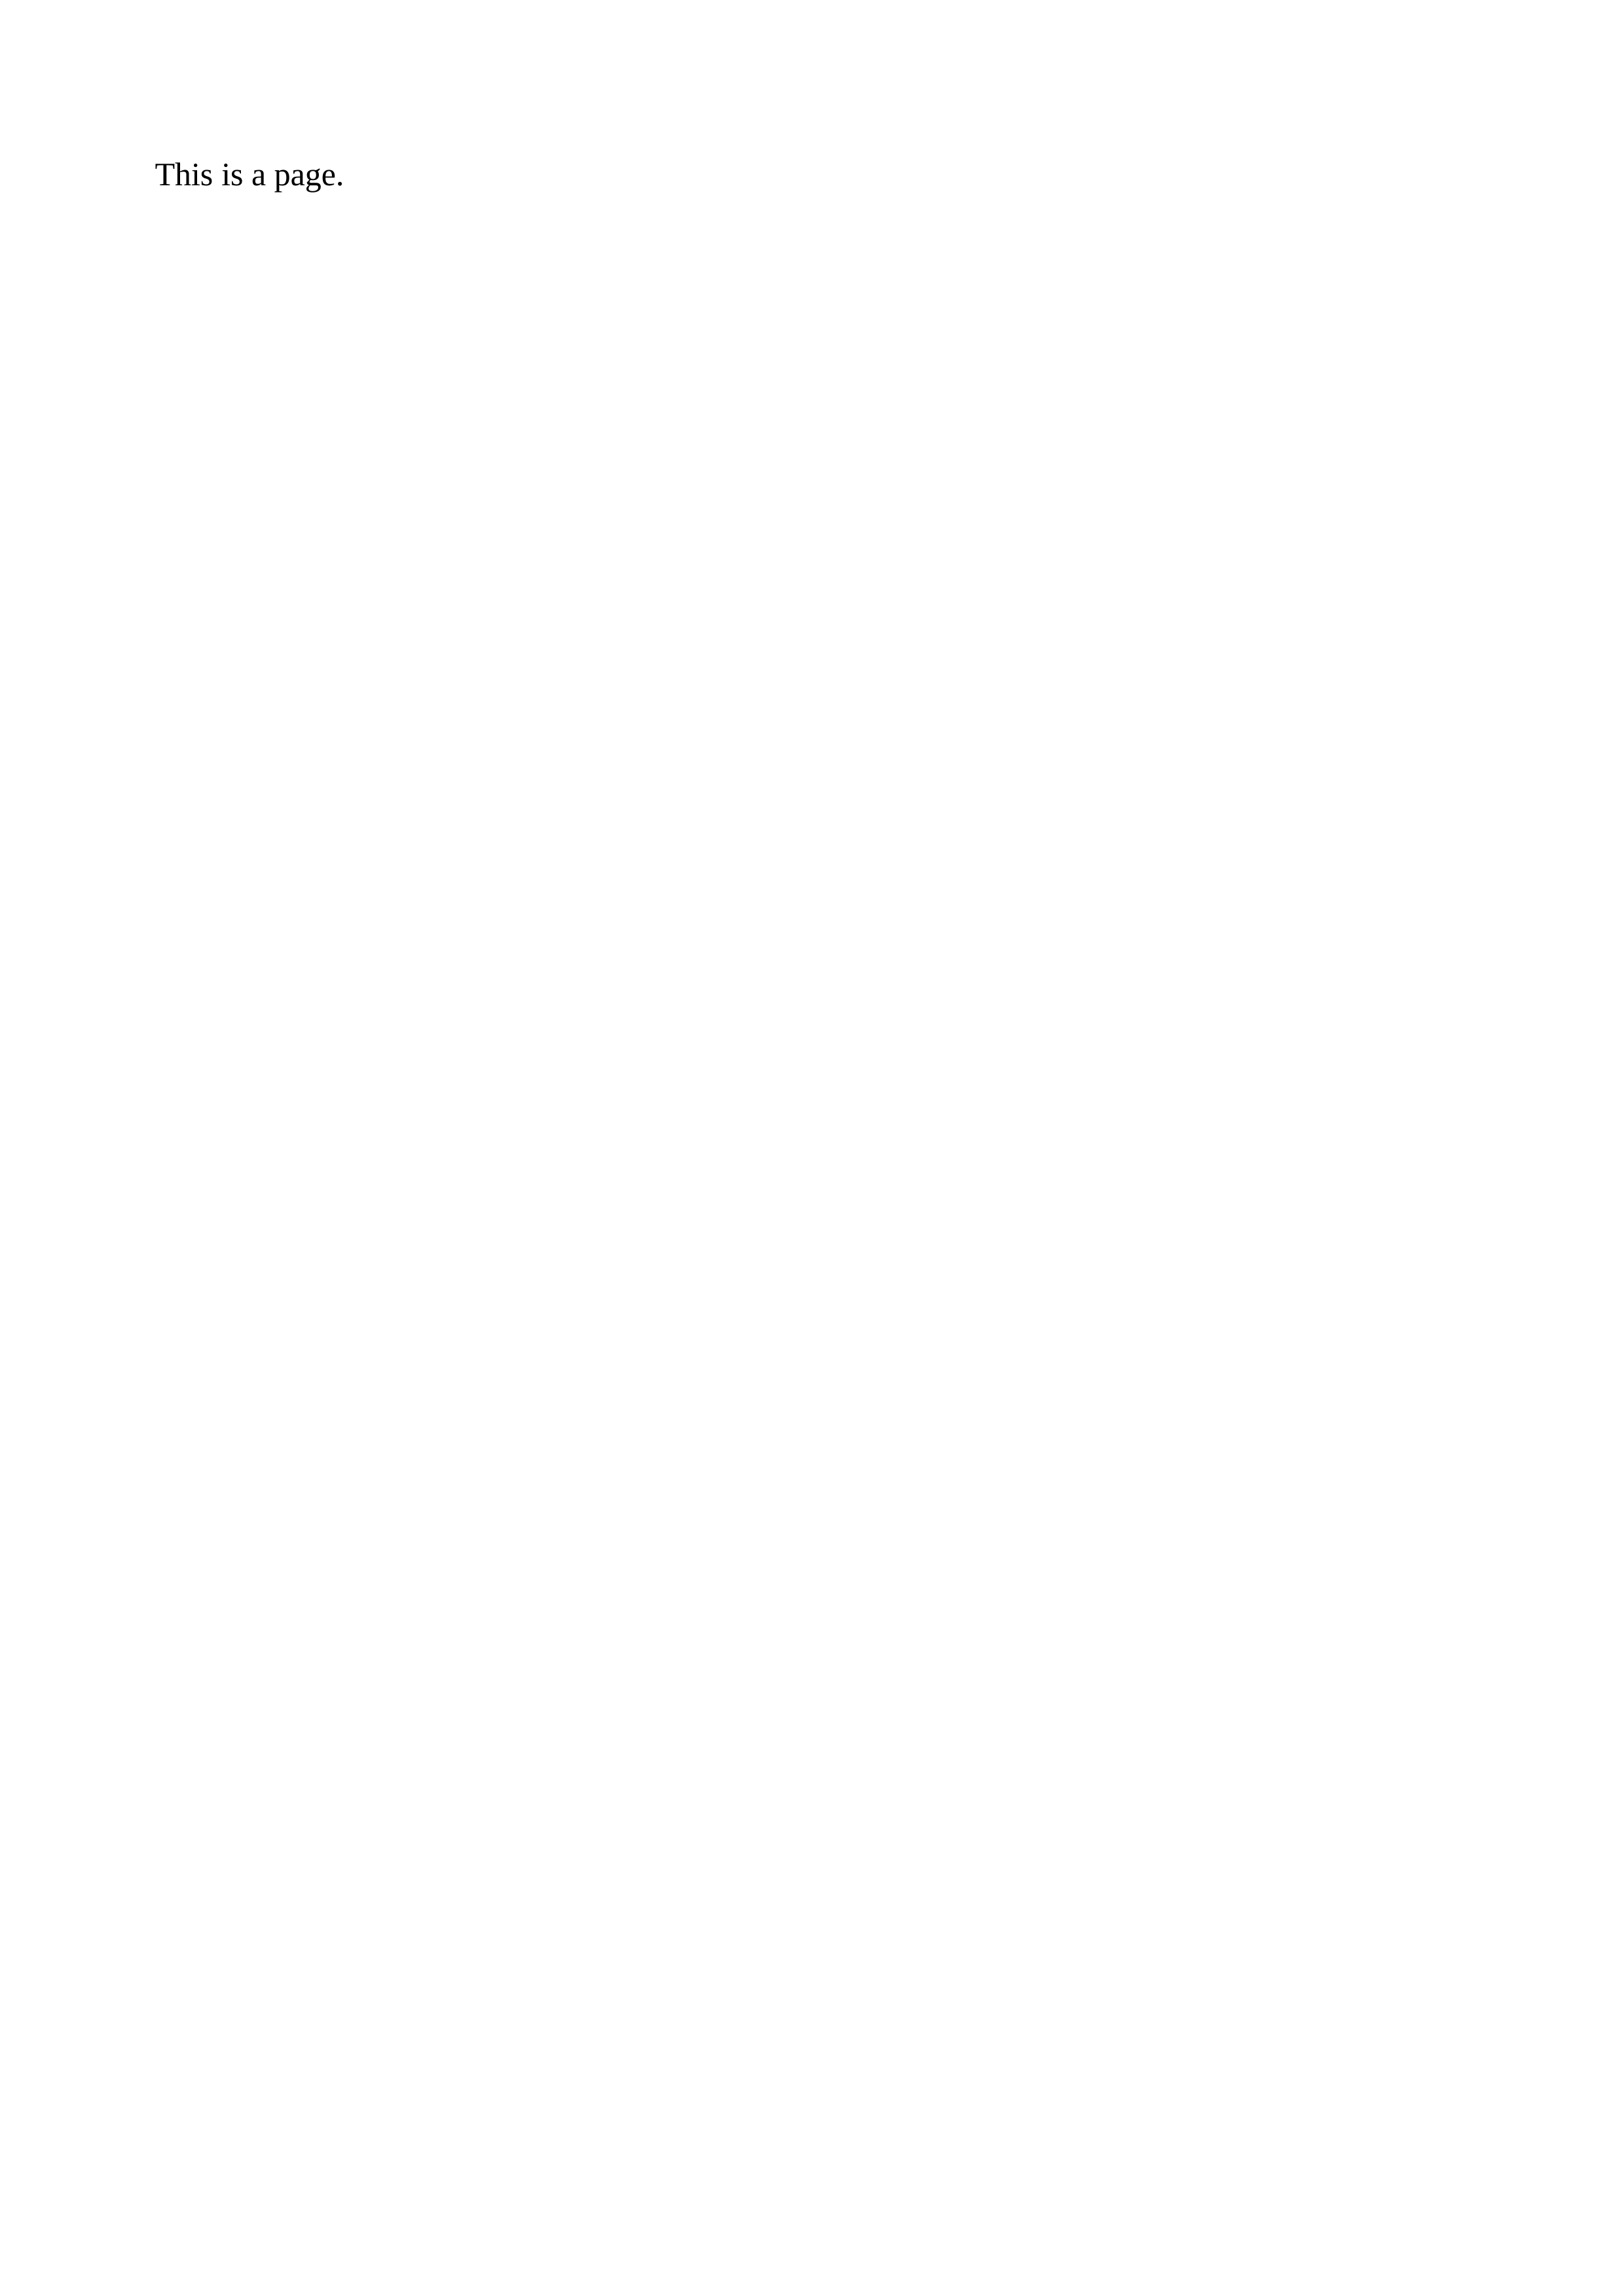

Image:
        origin: file:/Users/nmelnik/Library/Python/3.7/lib/python/site-packages/sparkocr/resources/ocr/pdfs/multiplepages/text_3_pages.pdf 
        width: 2480
        height: 3507
        mode: 10


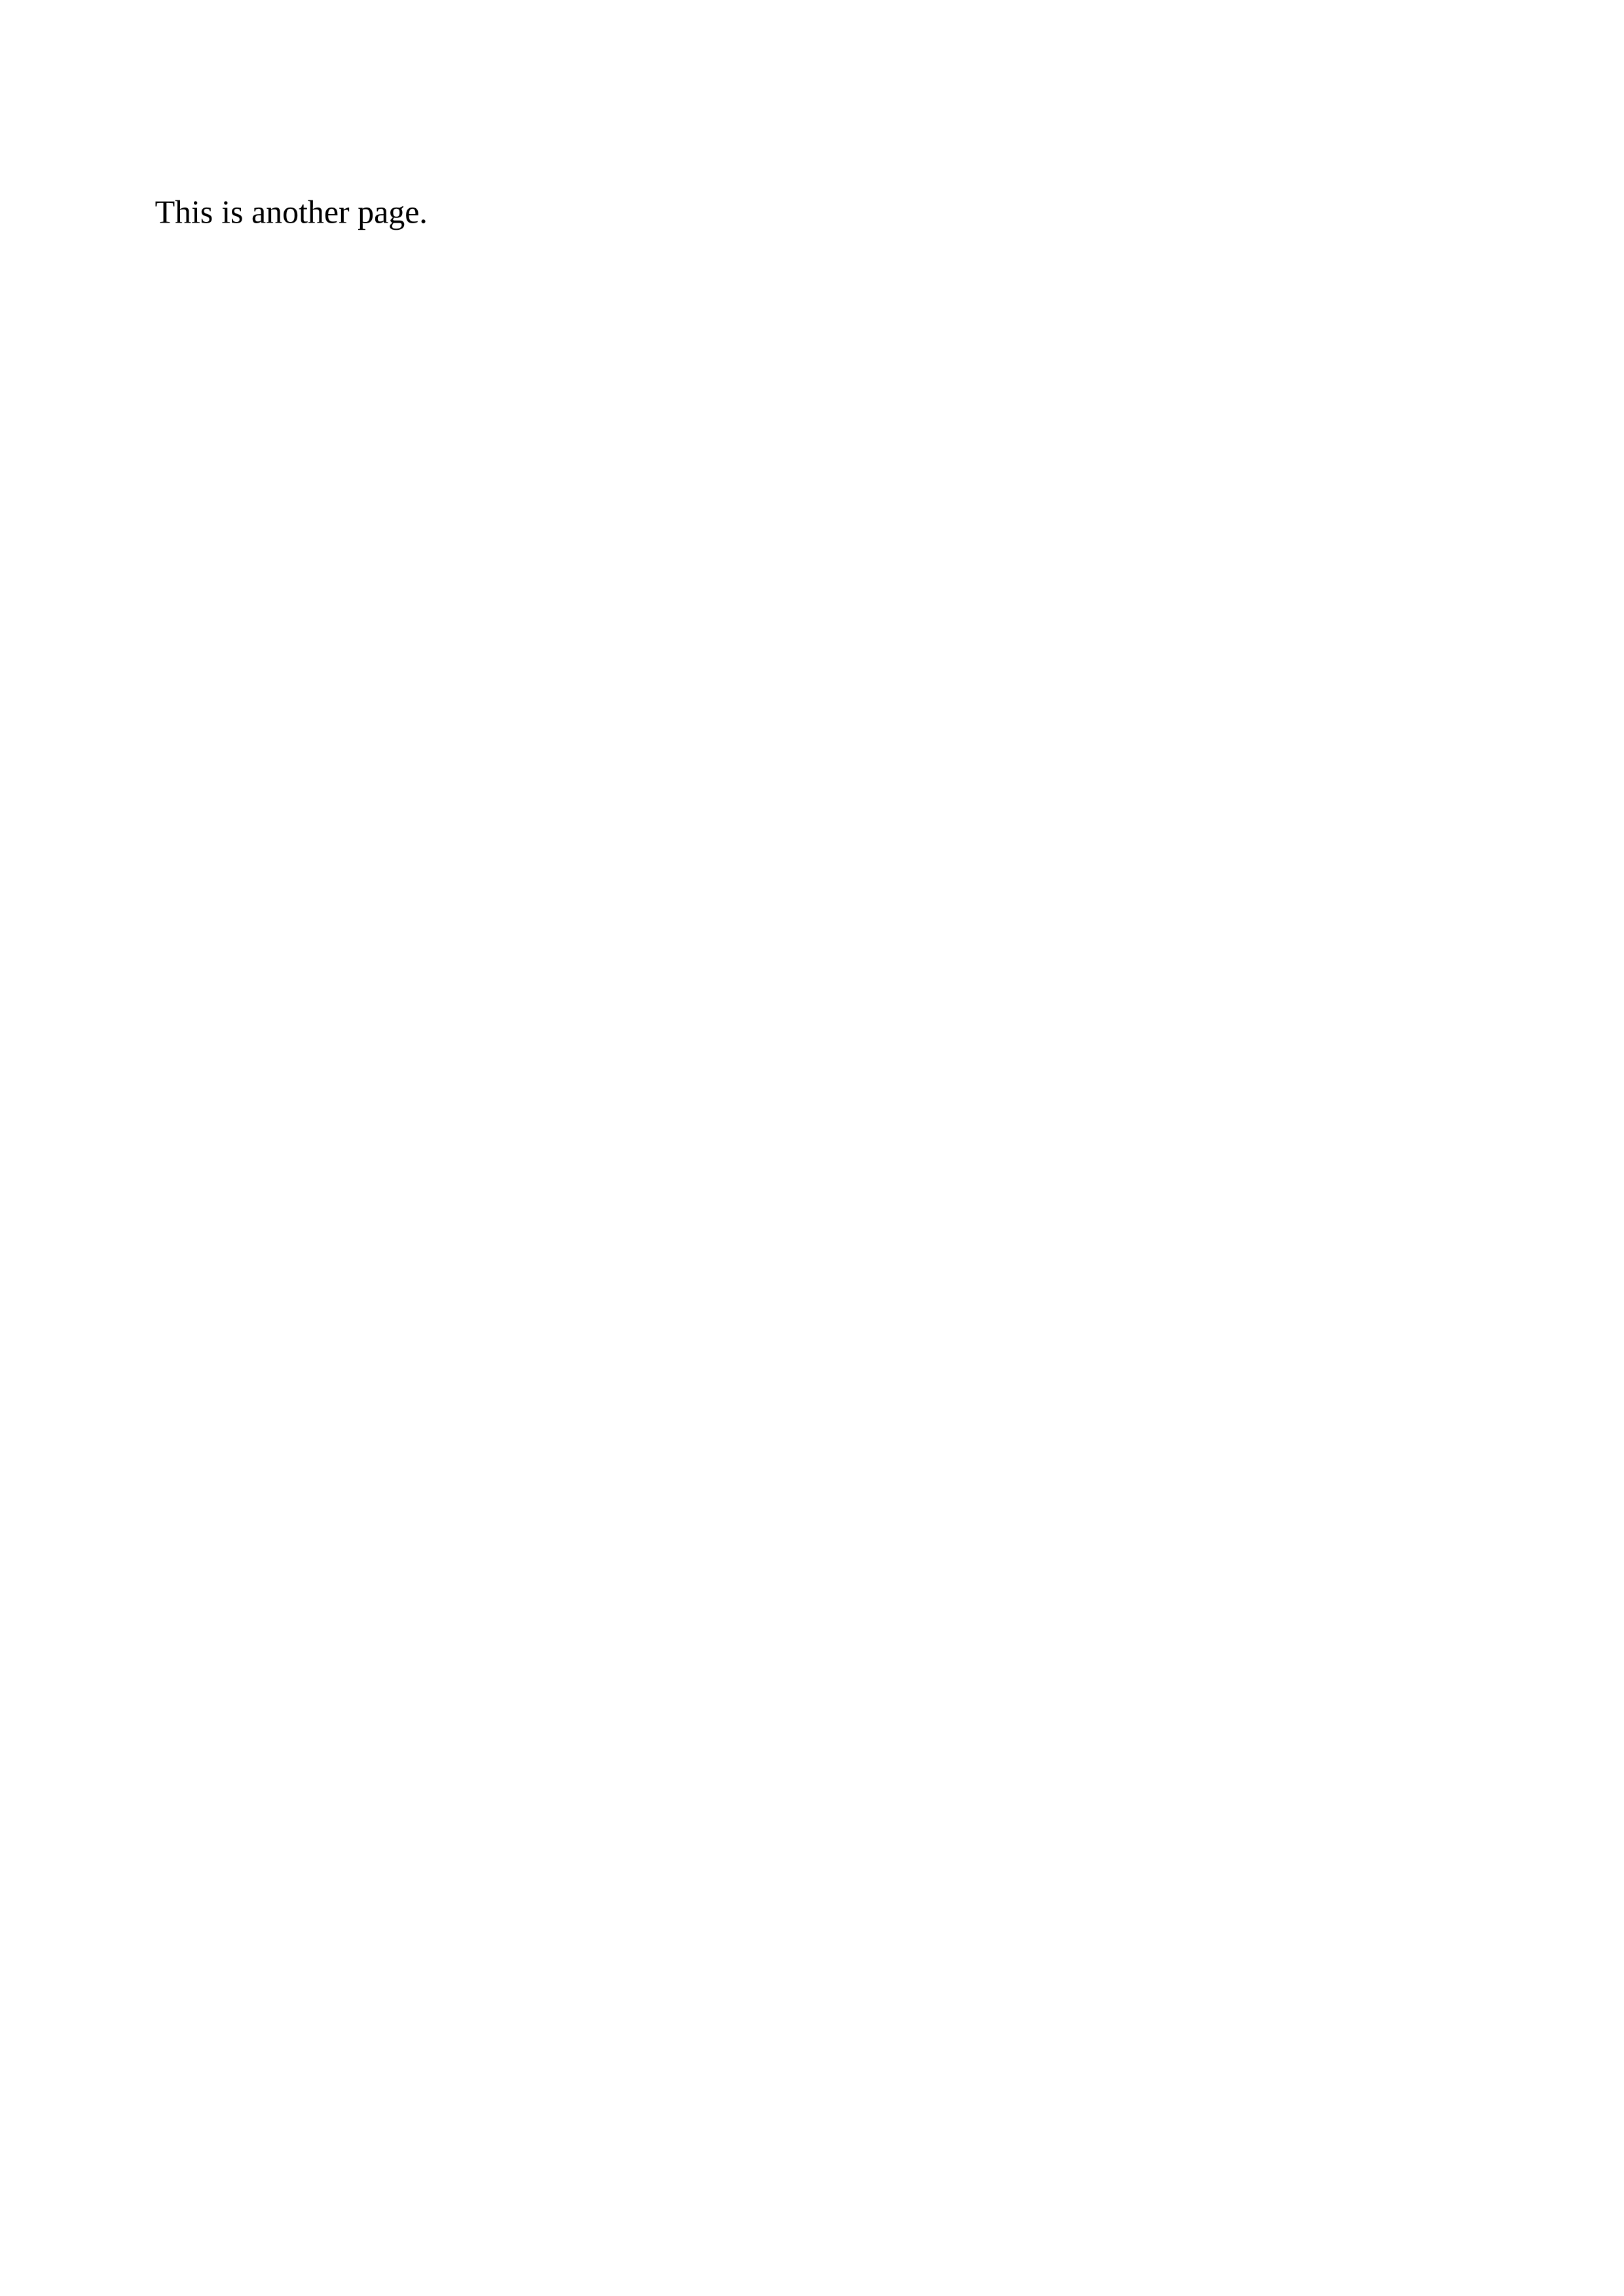

Image:
        origin: file:/Users/nmelnik/Library/Python/3.7/lib/python/site-packages/sparkocr/resources/ocr/pdfs/multiplepages/text_3_pages.pdf 
        width: 2480
        height: 3507
        mode: 10


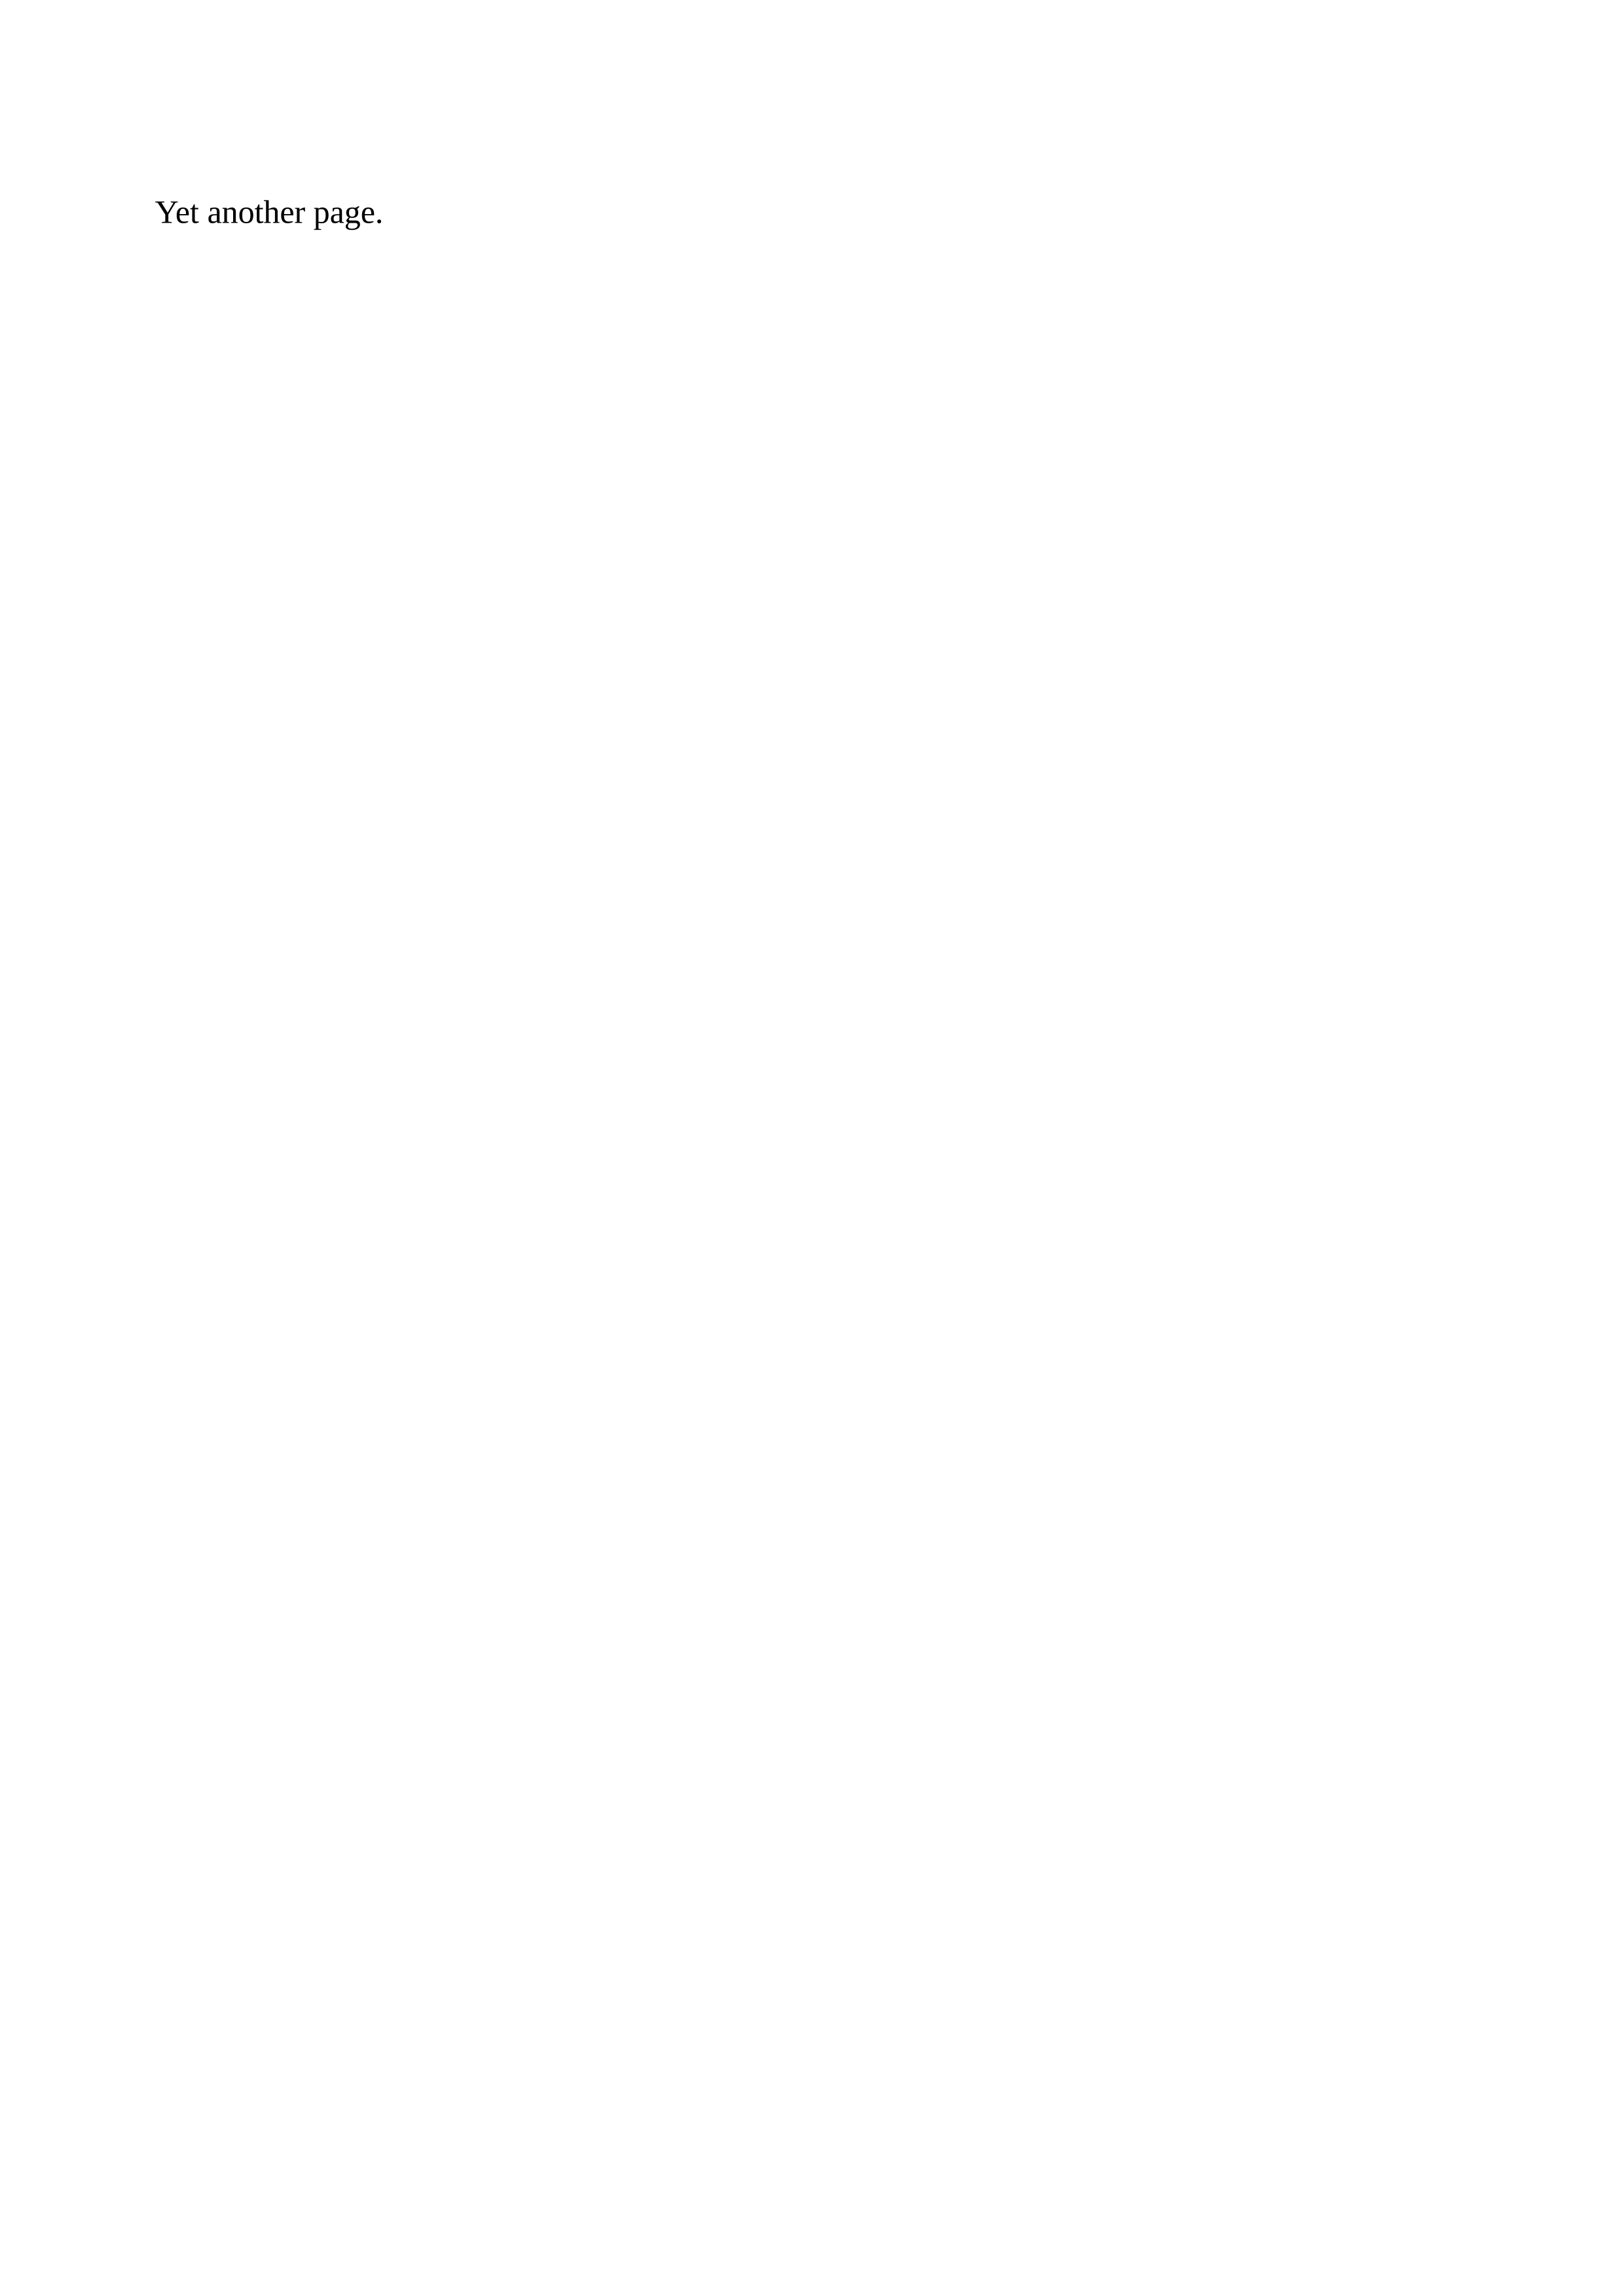

Image:
        origin: file:/Users/nmelnik/Library/Python/3.7/lib/python/site-packages/sparkocr/resources/ocr/pdfs/multiplepages/image_3_pages.pdf 
        width: 2666
        height: 3666
        mode: 10


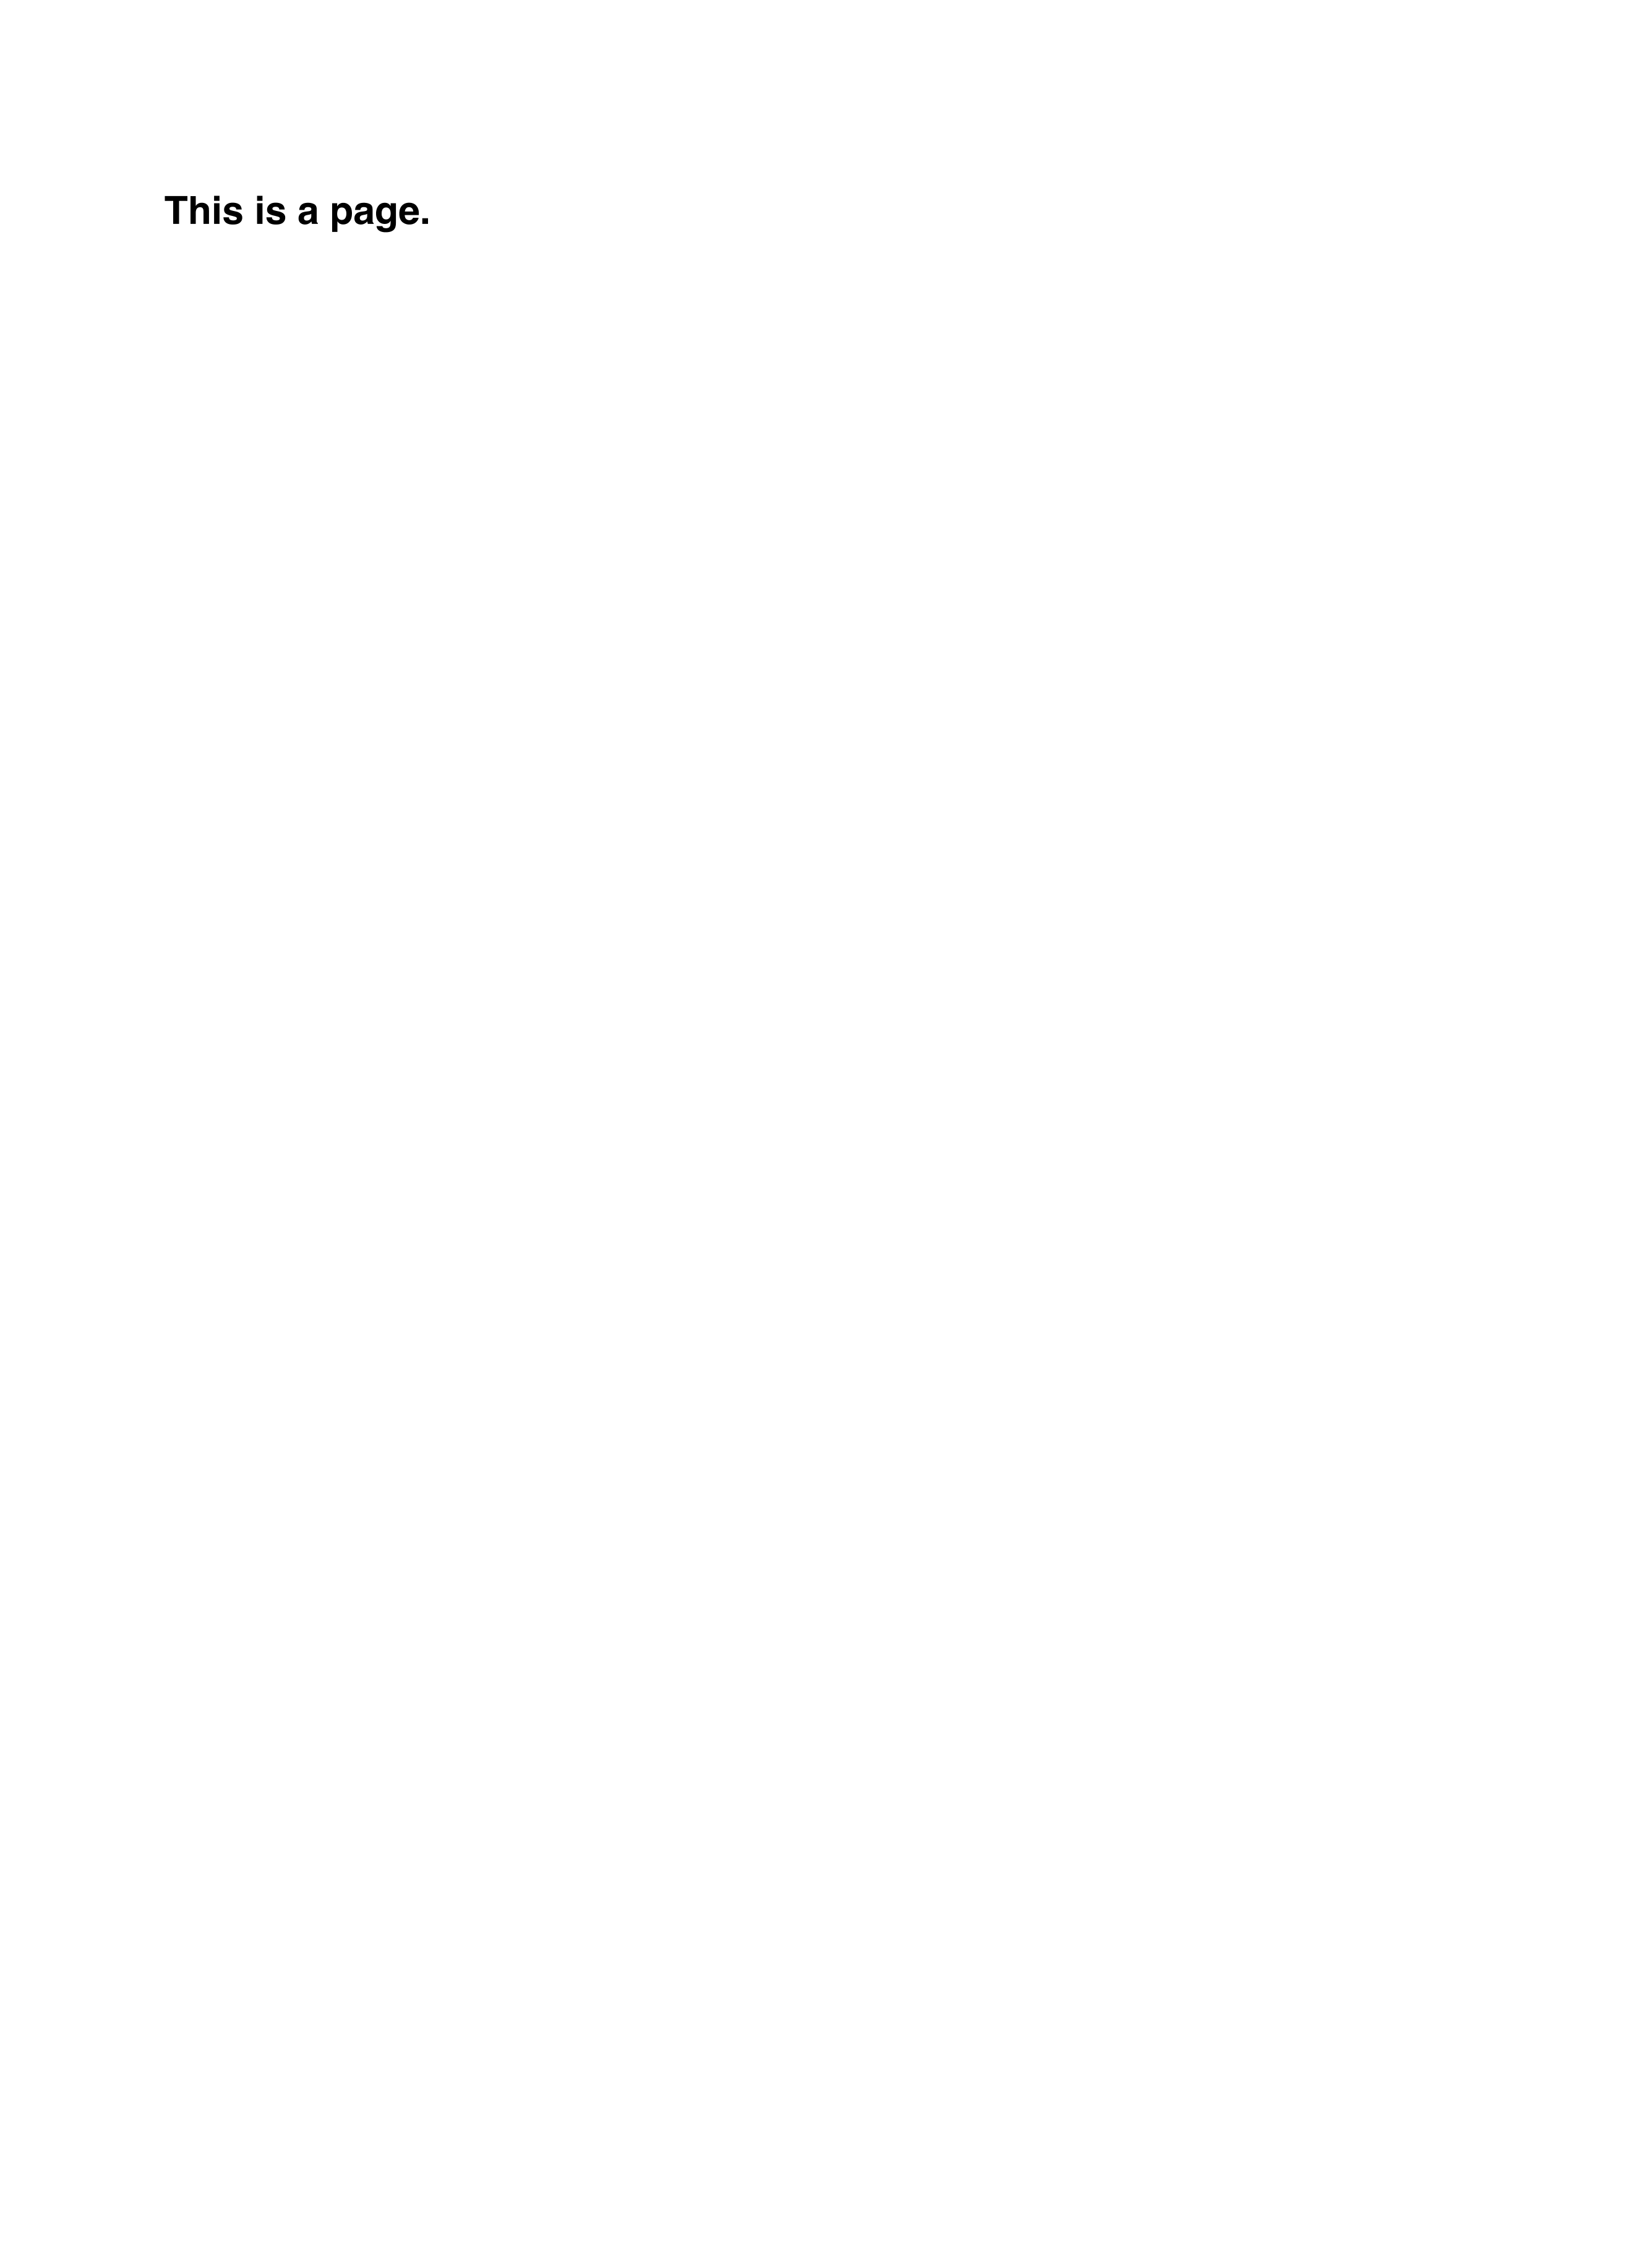

Image:
        origin: file:/Users/nmelnik/Library/Python/3.7/lib/python/site-packages/sparkocr/resources/ocr/pdfs/multiplepages/image_3_pages.pdf 
        width: 2666
        height: 3666
        mode: 10


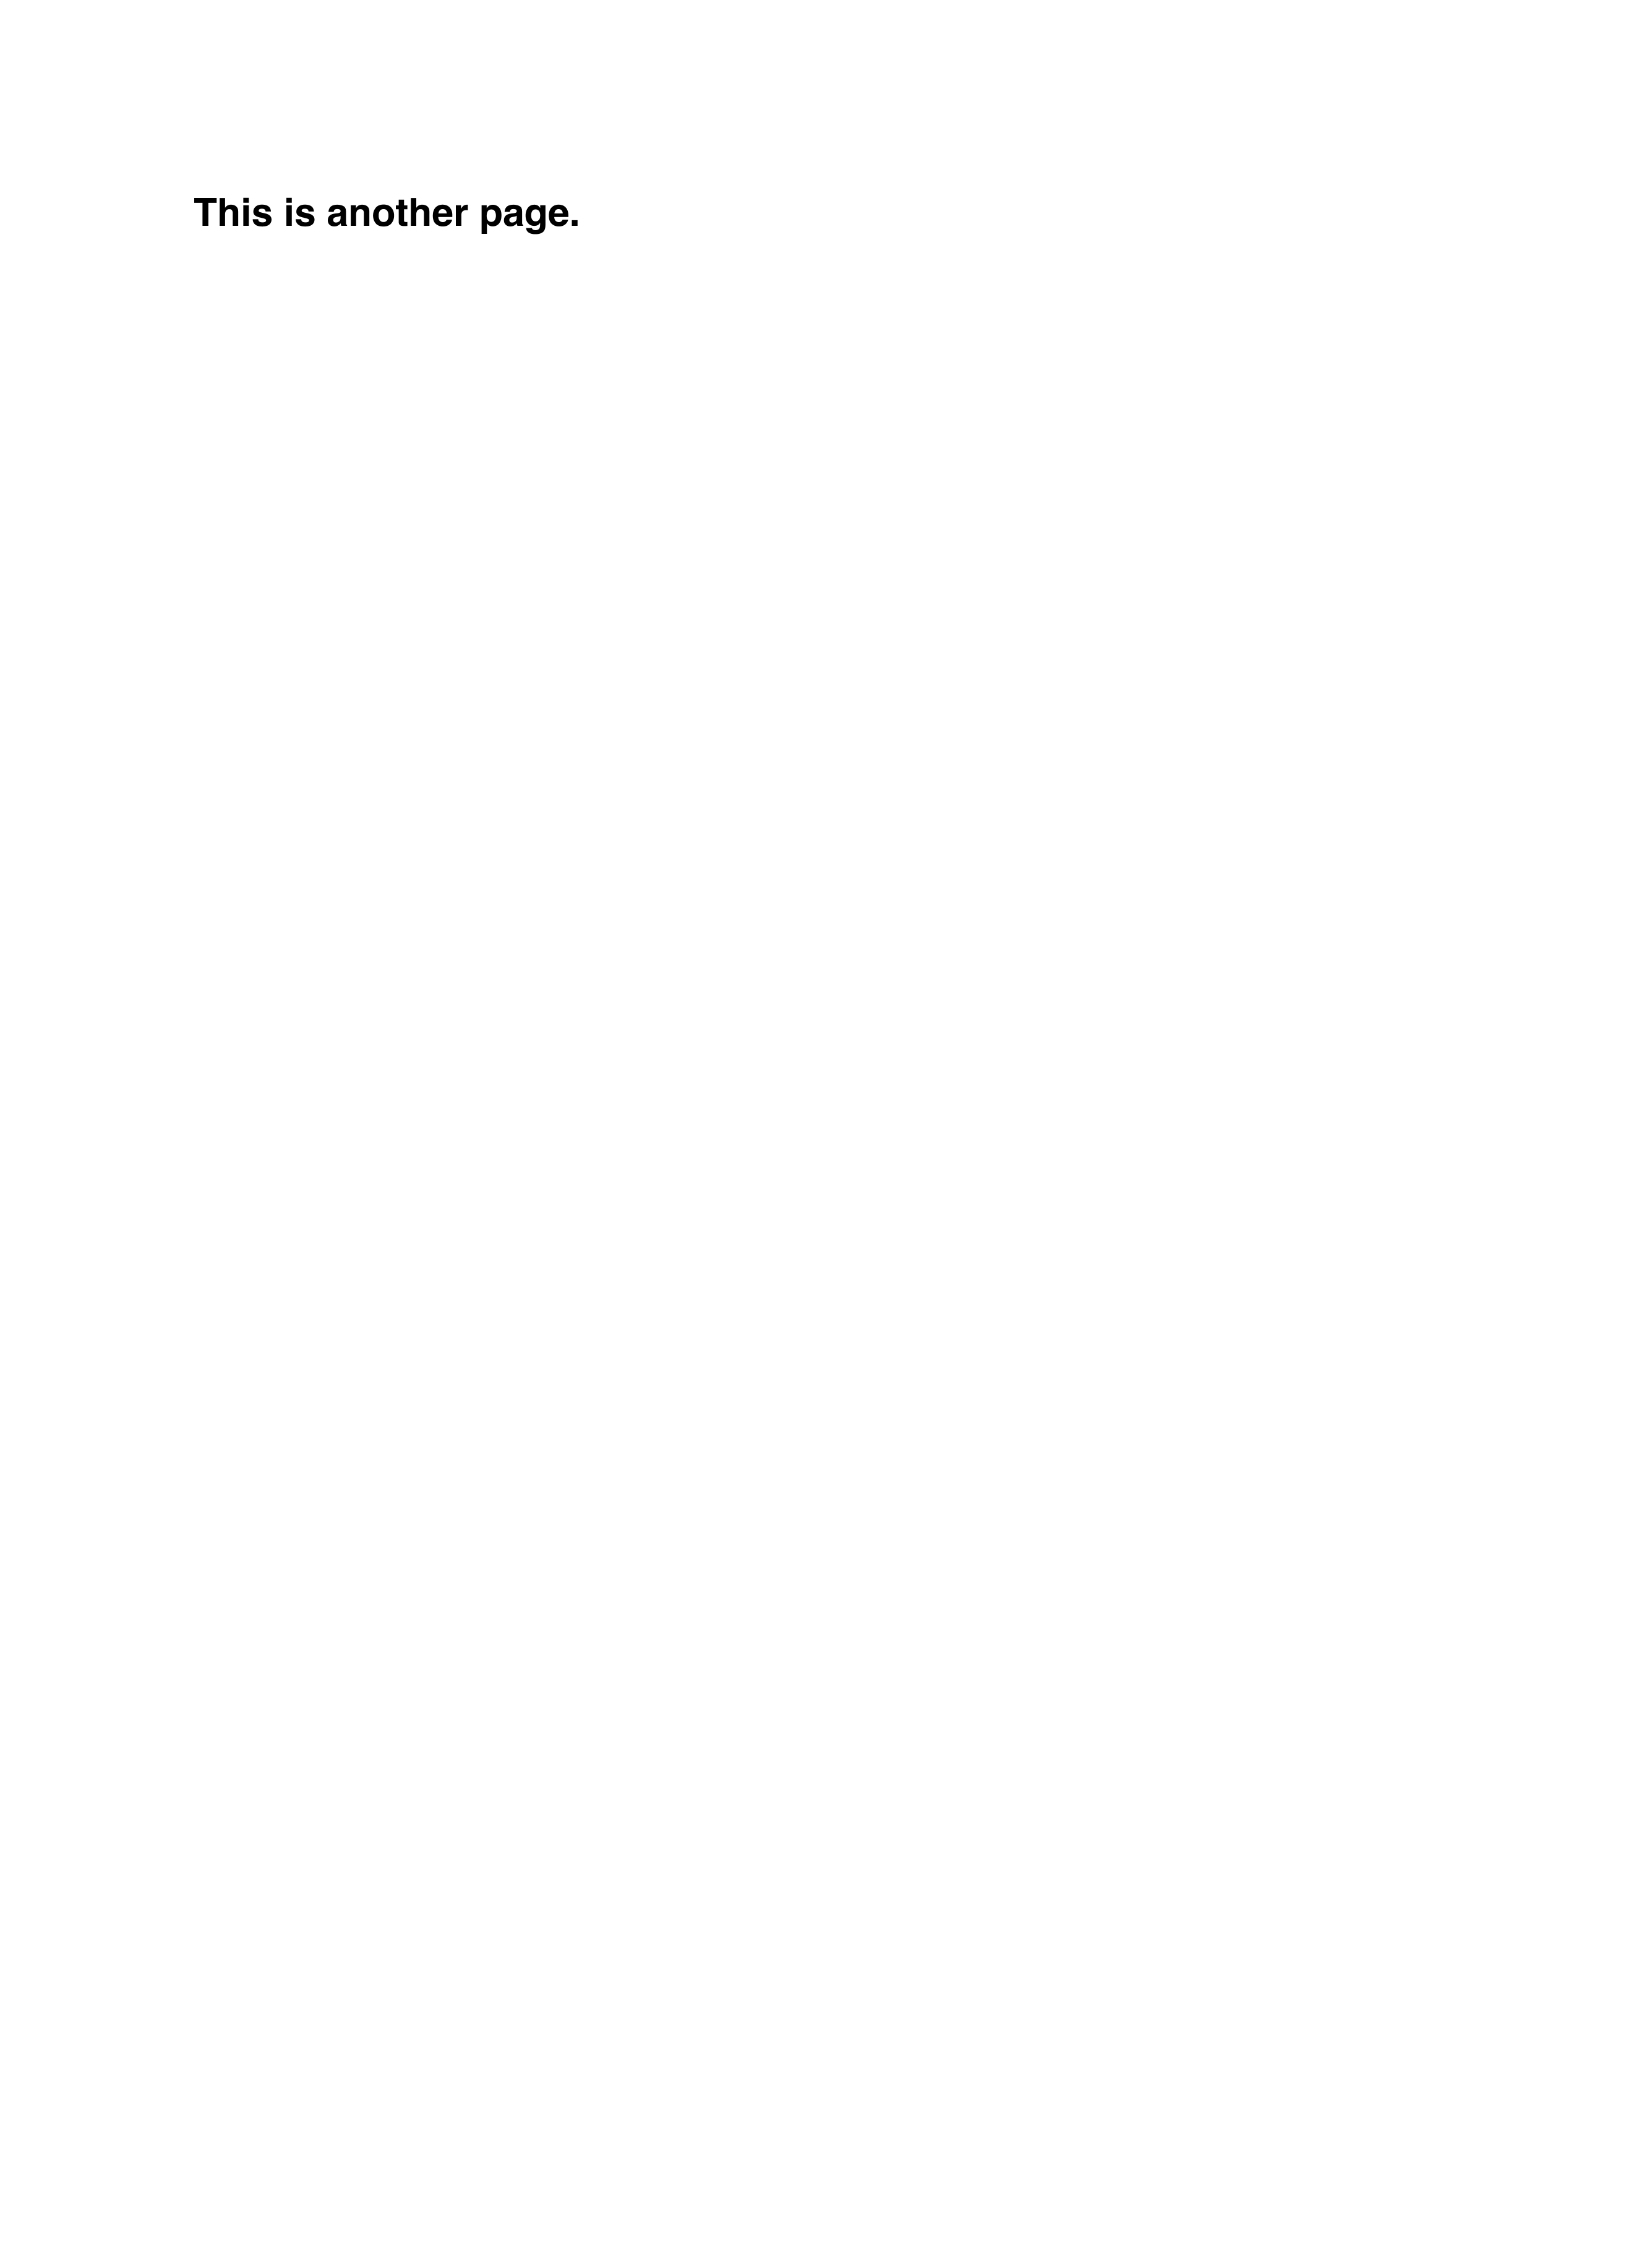

Image:
        origin: file:/Users/nmelnik/Library/Python/3.7/lib/python/site-packages/sparkocr/resources/ocr/pdfs/multiplepages/image_3_pages.pdf 
        width: 2666
        height: 3666
        mode: 10


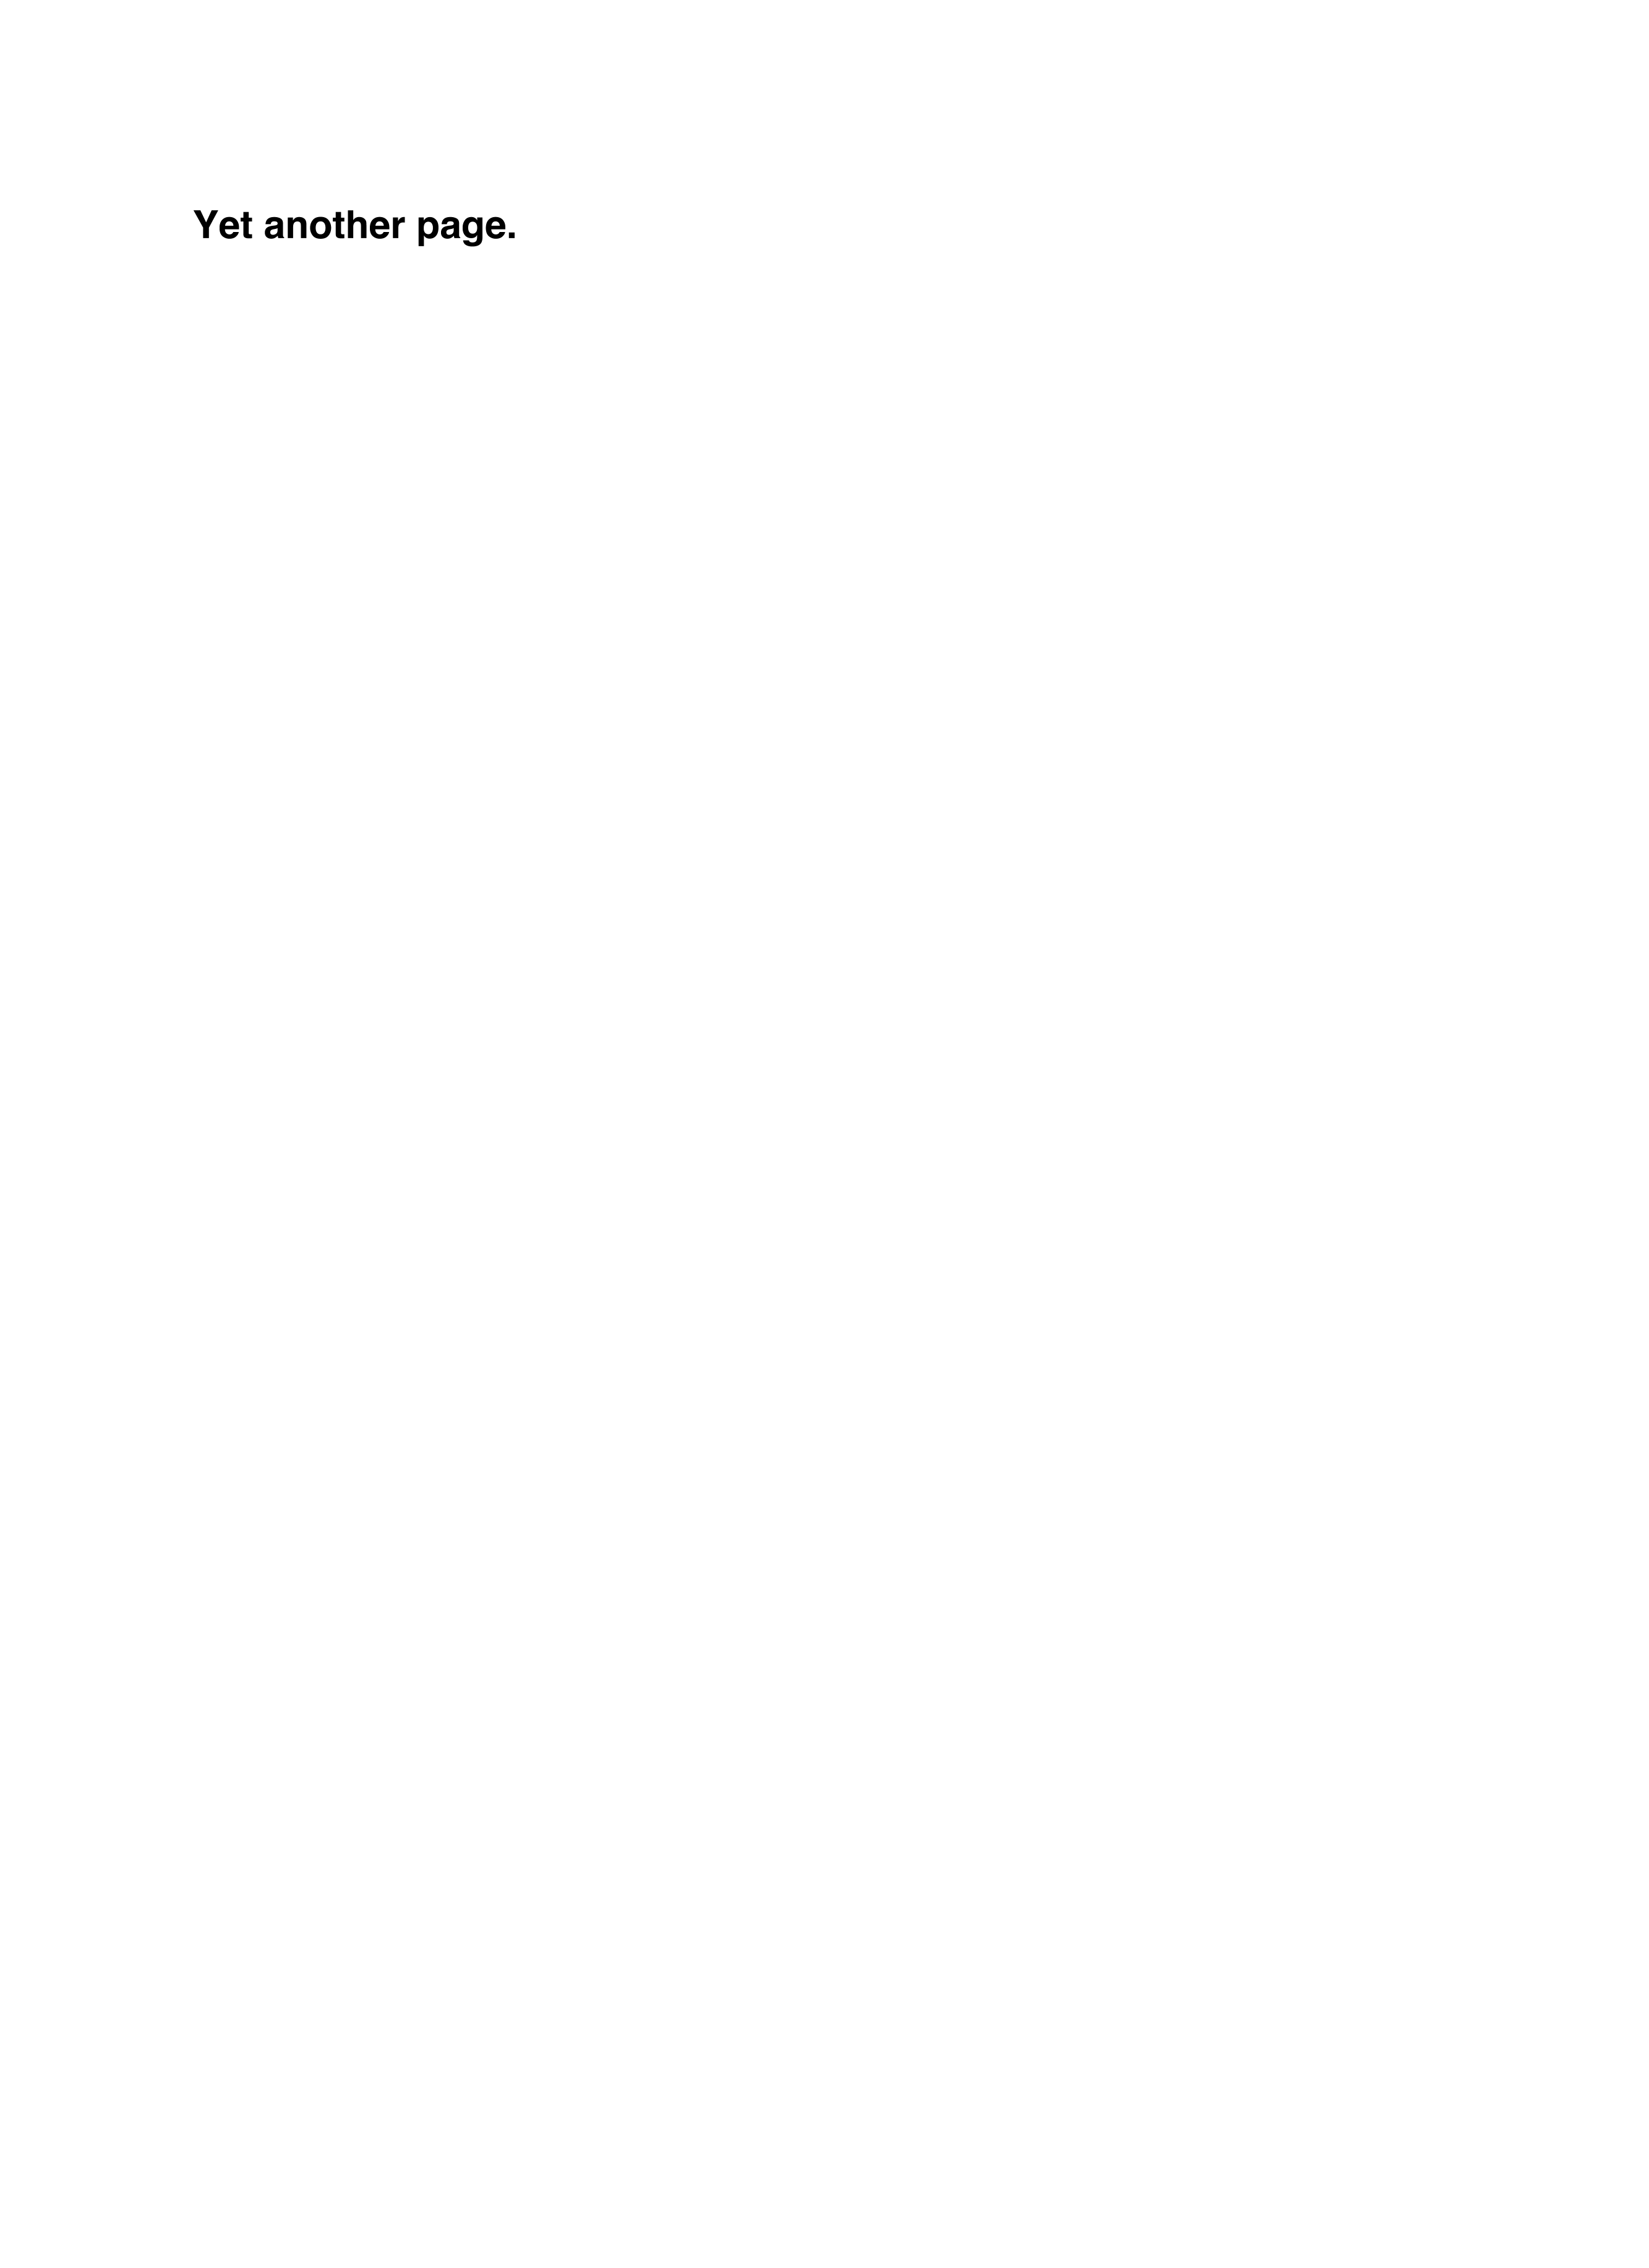

In [14]:
image_df = PdfToImage() \
    .setInputCol("pdf") \
    .setOutputCol("image") \
    .transform(result.select("pdf", "path"))
for r in image_df.collect():
    display_image(r.image)

In [47]:
result.unpersist()

DataFrame[path: string, text: array<string>, pdf: binary, exception: string]

In [57]:
%%bash
rm -r -f result.pdf